# K-means with text data

In [1]:
import pandas as pd                                                  # see below for install instruction
import matplotlib.pyplot as plt                                # plotting
import numpy as np                                             # dense matrices
from scipy.sparse import csr_matrix                            # sparse matrices
from sklearn.preprocessing import normalize                    # normalizing vectors
from sklearn.metrics import pairwise_distances                 # pairwise distances
import sys      
import os
%matplotlib inline

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']

    return csr_matrix( (data, indices, indptr), shape)

In [4]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')
map_index_to_word = pd.read_json('people_wiki_map_index_to_word.json',typ='series')

In [5]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## Implement k-means

In [6]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

In [7]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(dist)

[[1.41000789 1.36894636]
 [1.40935215 1.41023886]
 [1.39855967 1.40890299]
 ...
 [1.41108296 1.39123646]
 [1.41022804 1.31468652]
 [1.39899784 1.41072448]]


In [8]:
dist = pairwise_distances(tf_idf[430,:],tf_idf[1,:])

In [9]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check your code again')

Pass


In [11]:
dist

array([[1.40713107]])

In [12]:
# Students should write code here
distances = dist
closest_cluster = np.argmin(dist)

In [13]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check your code again')

Pass


In [14]:
# Students should write code here
def arg(distances):
    cluster_assignment = list()
    for i in range(0,len(distances)):
        cluster_assignment.append( np.argmin(distances[i]))
    return np.array(cluster_assignment)
centroids = tf_idf[0:3,:]
distances = pairwise_distances(tf_idf,centroids)
cluster_assignment = arg(distances)

In [15]:
if len(cluster_assignment)==59071 and \
   np.array_equal(np.bincount(cluster_assignment), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check your code again.')

Pass


In [16]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data,centroids)
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = arg(distances_from_centroids)
    
    return cluster_assignment

In [17]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check your code again.')

Pass


## Revising clusters

In [18]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [19]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)

[0 1 0]


In [20]:
cluster_assignment==1

array([False,  True, False])

In [21]:
cluster_assignment==0

array([ True, False,  True])

In [22]:
data[cluster_assignment==1]

array([[0., 0., 0.]])

In [24]:
data[cluster_assignment==0]

array([[1., 2., 0.],
       [2., 2., 0.]])

In [25]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

In [26]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [27]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


## Assessing convergence

In [28]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [29]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

In [30]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data,centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data,k,cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data,k,centroids,cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [32]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

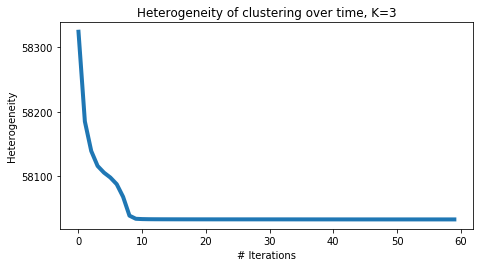

In [33]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [34]:
np.bincount(cluster_assignment)

array([19595, 10427, 29049], dtype=int64)

In [37]:
k = 10
heterogeneity = {}
import time
start = time.time()
quiz_ans = list()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    print(max(np.bincount(cluster_assignment)))
    quiz_ans.append(max(np.bincount(cluster_assignment)))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442
18047
seed=020000, heterogeneity=57533.20100
15779
seed=040000, heterogeneity=57512.69257
18132
seed=060000, heterogeneity=57466.97925
17900
seed=080000, heterogeneity=57494.92990
17582
seed=100000, heterogeneity=57484.42210
16969
seed=120000, heterogeneity=57554.62410
16481
281.7531795501709


In [39]:
print(min(quiz_ans),max(quiz_ans))

15779 18132


In [42]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

In [43]:
k = 10
heterogeneity_smart = {}
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57441.33298
seed=020000, heterogeneity=57457.50383
seed=040000, heterogeneity=57469.82237
seed=060000, heterogeneity=57503.05355
seed=080000, heterogeneity=57464.05684
seed=100000, heterogeneity=57487.57010
seed=120000, heterogeneity=57534.79120
380.7902989387512


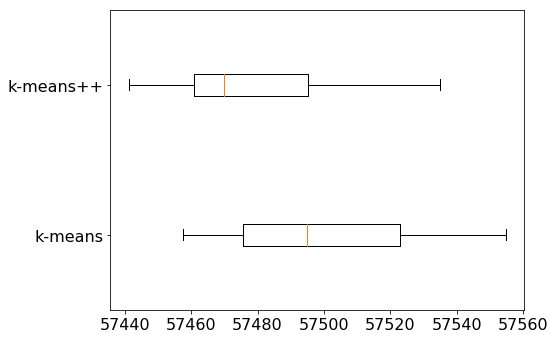

In [48]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [49]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_assignment = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
        # YOUR CODE HERE
        initial_centroids =  smart_initialize(data,k,seed)
        
        # Run k-means
        # YOUR CODE HERE
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        # YOUR CODE HERE
        heterogeneity[seed] = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is lower than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

## How to choose K

2
10
25
50
100


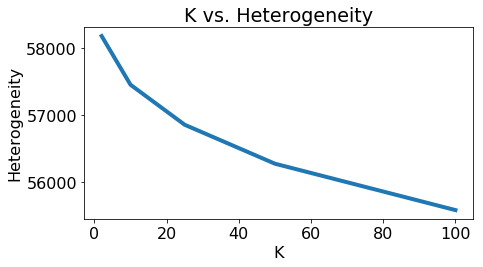

In [50]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

filename = 'kmeans-arrays.npz'

heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]

if os.path.exists(filename):
    arrays = np.load(filename)
    centroids = {}
    cluster_assignment = {}
    for k in k_list:
        print(k)
        sys.stdout.flush()
        '''To save memory space, do not load the arrays from the file right away. We use
           a technique known as lazy evaluation, where some expressions are not evaluated
           until later. Any expression appearing inside a lambda function doesn't get
           evaluated until the function is called.
           Lazy evaluation is extremely important in memory-constrained setting, such as
           an Amazon EC2 t2.micro instance.'''
        centroids[k] = lambda k=k: arrays['centroids_{0:d}'.format(k)]
        cluster_assignment[k] = lambda k=k: arrays['cluster_assignment_{0:d}'.format(k)]
        score = compute_heterogeneity(tf_idf, k, centroids[k](), cluster_assignment[k]())
        heterogeneity_values.append(score)
    
    plot_k_vs_heterogeneity(k_list, heterogeneity_values)

else:
    print('File not found. Skipping.')

## Visualize clusters of documents

In [55]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_assignment, k, map_index_to_word, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    
    print('==========================================================')

    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word.index[idx[i]], centroids[c,idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_assignment!=c] = float('inf') # remove non-members from consideration
            nearest_neighbors = distances.argsort()
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki.iloc[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki.iloc[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

In [56]:
'''Notice the extra pairs of parentheses for centroids and cluster_assignment.
   The centroid and cluster_assignment are still inside the npz file,
   and we need to explicitly indicate when to load them into memory.'''
visualize_document_clusters(wiki, tf_idf, centroids[2](), cluster_assignment[2](), 2, map_index_to_word)

Cluster 0    
serieslong:0.025
bostonas:0.017
33story:0.012
gan:0.011
efovi:0.011


* Anita Kunz                                         0.97401
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Janet Jackson                                      0.97472
  janet damita jo jackson born may 16 1966 is an american singer songwriter and actress know
  n for a series of sonically innovative socially conscious and

* Madonna (entertainer)                              0.97475
  madonna louise ciccone tkoni born august 16 1958 is an american singer songwriter actress 
  and businesswoman she achieved popularity by pushing the boundaries of lyrical

* %C3%81ine Hyland                                   0.97536
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Jane Fonda               

In [57]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k, map_index_to_word)

Cluster 0    
allmvfc:0.020
scientistagreed:0.014
gan:0.011
psihomodo:0.010
2001pasithee:0.010


* Wilson McLean                                      0.97479
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Anton Hecht                                        0.97748
  anton hecht is an english artist born in london in 2007 he asked musicians from around the
   durham area to contribute to a soundtrack for

* David Salle                                        0.97800
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Vipin Sharma                                       0.97805
  vipin sharma is an indian actor born in new delhi he is a graduate of national school of d
  rama new delhi india and the canadian

* Paul Swadel                                        0.97823


* Todd Curley                                        0.92731
  todd curley born 14 january 1973 is a former australian rules footballer who played for co
  llingwood and the western bulldogs in the australian football league

* Ashley Prescott                                    0.92992
  ashley prescott born 11 september 1972 is a former australian rules footballer he played w
  ith the richmond and fremantle football clubs in the afl between

* Pete Richardson                                    0.93204
  pete richardson born october 17 1946 in youngstown ohio is a former american football defe
  nsive back in the national football league and former college head

* Nathan Brown (Australian footballer born 1976)     0.93561
  nathan daniel brown born 14 august 1976 is an australian rules footballer who played for t
  he melbourne demons in the australian football leaguehe was drafted

* Earl Spalding                                      0.93654
  earl spalding born 11 march 1965 in sou

In [58]:
np.bincount(cluster_assignment[10]())

array([17602,  3415,  3535,  1736,  6445,  2552,  7106,  7155,   599,
        8926], dtype=int64)

In [59]:
visualize_document_clusters(wiki, tf_idf, centroids[25](), cluster_assignment[25](), 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
blitzattack:0.077
addie:0.048
recordingstheir:0.046
buntingfrom:0.038
hettingers:0.038

Cluster 1    
preposition:0.054
2210:0.033
hundreaarsvisningen:0.032
efovi:0.031
allenshortly:0.029

Cluster 2    
ibnez:0.216
jeffnominated:0.134
usyd:0.065
sibinki:0.052
19771992according:0.047

Cluster 3    
zahida:0.065
pricepottenger:0.042
newsweekkhan:0.031
trag:0.027
slowburn:0.023

Cluster 4    
incertidumbre:0.025
2012frostad:0.023
hareher:0.022
dumbblonde:0.022
disbandedkirwan:0.020

Cluster 5    
lopilato:0.160
madeamhali:0.056
1200in:0.044
zahida:0.043
pricepottenger:0.042

Cluster 6    
efovi:0.044
2210:0.037
rezas:0.035
wone:0.034
chandanapally:0.031

Cluster 7    
pricepottenger:0.066
cranberries:0.058
movessince:0.051
zahida:0.045
popclub:0.043

Cluster 8    
madeley:0.095
dilber:0.056
qafl:0.054
tray:0.052
arvo:0.051

Cluster 9    
hilger:0.146
repertoryborn:0.096
1982read:0.053
postmodernismlike:0.048
preposition:0.043

Cluster 10    
agency:0.075
substantialhe:0.050


In [60]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k](), cluster_assignment[k](), k,
                            map_index_to_word, display_content=False)
# turn off text for brevity -- turn it on if you are curious ;)

Cluster 0    
isolates:0.137
zincavage:0.082
asiabased:0.056
pantherslabowitch:0.053
machairitsas:0.050

Cluster 1    
keimyung:0.170
razed:0.085
pozsgay:0.083
lectrices:0.072
1065ray:0.058

Cluster 2    
proa:0.247
examinationspaulker:0.069
10093:0.056
terribles:0.031
berr:0.029

Cluster 3    
queer:0.181
yearhansen:0.121
rostersleeth:0.042
awardspreviously:0.036
psihomodo:0.034

Cluster 4    
huld:0.309
1999derek:0.220
stagelavin:0.066
kartvelology:0.041
affiliatechoi:0.031

Cluster 5    
franquin:0.192
turhapuro:0.127
wayak:0.054
bruschi:0.046
ebu:0.042

Cluster 6    
hettingers:0.059
addie:0.053
eba:0.051
lohiau:0.049
damepazan:0.044

Cluster 7    
verwaltung:0.105
childrenseveral:0.099
movessince:0.071
pricepottenger:0.067
barns:0.061

Cluster 8    
hilger:0.065
efovi:0.048
preposition:0.045
2210:0.043
repertoryborn:0.043

Cluster 9    
raben:0.086
greno:0.076
prospectsaustin:0.061
qasr:0.053
foreignnational:0.040

Cluster 10    
serieslong:0.188
bostonas:0.052
studentsresearchthr

kabalikat:0.282
nonviolence:0.183
saprang:0.094
campielloin:0.046
lizarazoalfonso:0.027

Cluster 56    
ftlavallee:0.207
burkewhite:0.136
ungol:0.087
33story:0.080
pramukh:0.073

Cluster 57    
sderbergborn:0.035
councilwhite:0.027
placesspinning:0.026
recordingstheir:0.025
editorialhe:0.023

Cluster 58    
brasher:0.234
nanri:0.047
33story:0.039
conder:0.037
secondgrade:0.035

Cluster 59    
theologians:0.093
mclelland:0.052
seljuks:0.051
33story:0.048
conder:0.037

Cluster 60    
asiabased:0.127
mendras:0.059
propon:0.035
tahourdin:0.026
late2011:0.025

Cluster 61    
buytendijk:0.193
antzen:0.132
seiryo:0.052
2010shaw:0.038
etcslapdee:0.032

Cluster 62    
kenn:0.362
scriptons:0.109
championthree:0.084
serieslong:0.057
straka:0.044

Cluster 63    
ibnez:0.220
jeffnominated:0.138
usyd:0.067
sibinki:0.053
19771992according:0.048

Cluster 64    
blitzattack:0.148
recordingstheir:0.093
datebook:0.071
addie:0.051
actressrealizing:0.043

Cluster 65    
ssls:0.205
finglas:0.086
eros1988:0.

In [62]:
test = np.bincount(cluster_assignment[100]())
count = 0
for i in test:
    if i <236:
        count+=1
print(count)

29
